This notebook reads numpy arrays created by processMexicoData.ipynb. The processed data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

NB The notebook is set up for binary categories only ATM

In [ ]:
!pip install livelossplot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.ndimage
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the numpy arrays containing Sentinel image snippets

states = ["Aguascalientes", "Chiapas", "Durango", "Guanajuato", "Queretaro", "NuevoLeon",\
          "Sonora", "Yucatan"]
images_cat1 = []
images_cat0 = []

# The original datasets

for state in states:
  images_cat1.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat1.npy'))
  images_cat0.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat0.npy'))

images_cat1 = np.concatenate(images_cat1, axis=0)
images_cat0 = np.concatenate(images_cat0, axis=0)

print(f"There are {images_cat1.shape[0]} CAFO images")
print(f"There are {images_cat0.shape[0]} not-CAFO images")

There are 1096 CAFO images
There are 1036 not-CAFO images


In [5]:
# Create training, validation, and test datasets from those arrays

# Combine all the farm and not-farm images into a single array
images = np.concatenate([images_cat1, images_cat0], axis=0)

# Create an array of image labels
labels_cat1 = np.ones(len(images_cat1))
labels_cat0 = np.zeros(len(images_cat0))
labels = np.concatenate([labels_cat1, labels_cat0], axis=0)
labels = to_categorical(labels, num_classes=2)

# Randomly shuffle images and labels in unison
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.10, random_state=42)  # 10% for testing

# Split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=42)  # ~20% for validation

# Keep copies of original data as the arrays can get changed by the data generators
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

In [6]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [ ]:
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0,
                 weights_file=None):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'adam'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Load weights, if desired
    if weights_file is not None:
      model.load_weights(weights_file)

    # Compile the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Define early stopping + other callbacks. See
# machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.02,
                  verbose=2,
                  patience=10)

mc = ModelCheckpoint(
                    '/content/drive/MyDrive/best_model.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True
                    )

lr = ReduceLROnPlateau(
                      monitor='val_loss',
                      factor=0.5,
                      patience=5,
                      verbose=1,
                      min_lr=1e-6
                      )

pl = PlotLossesCallback()

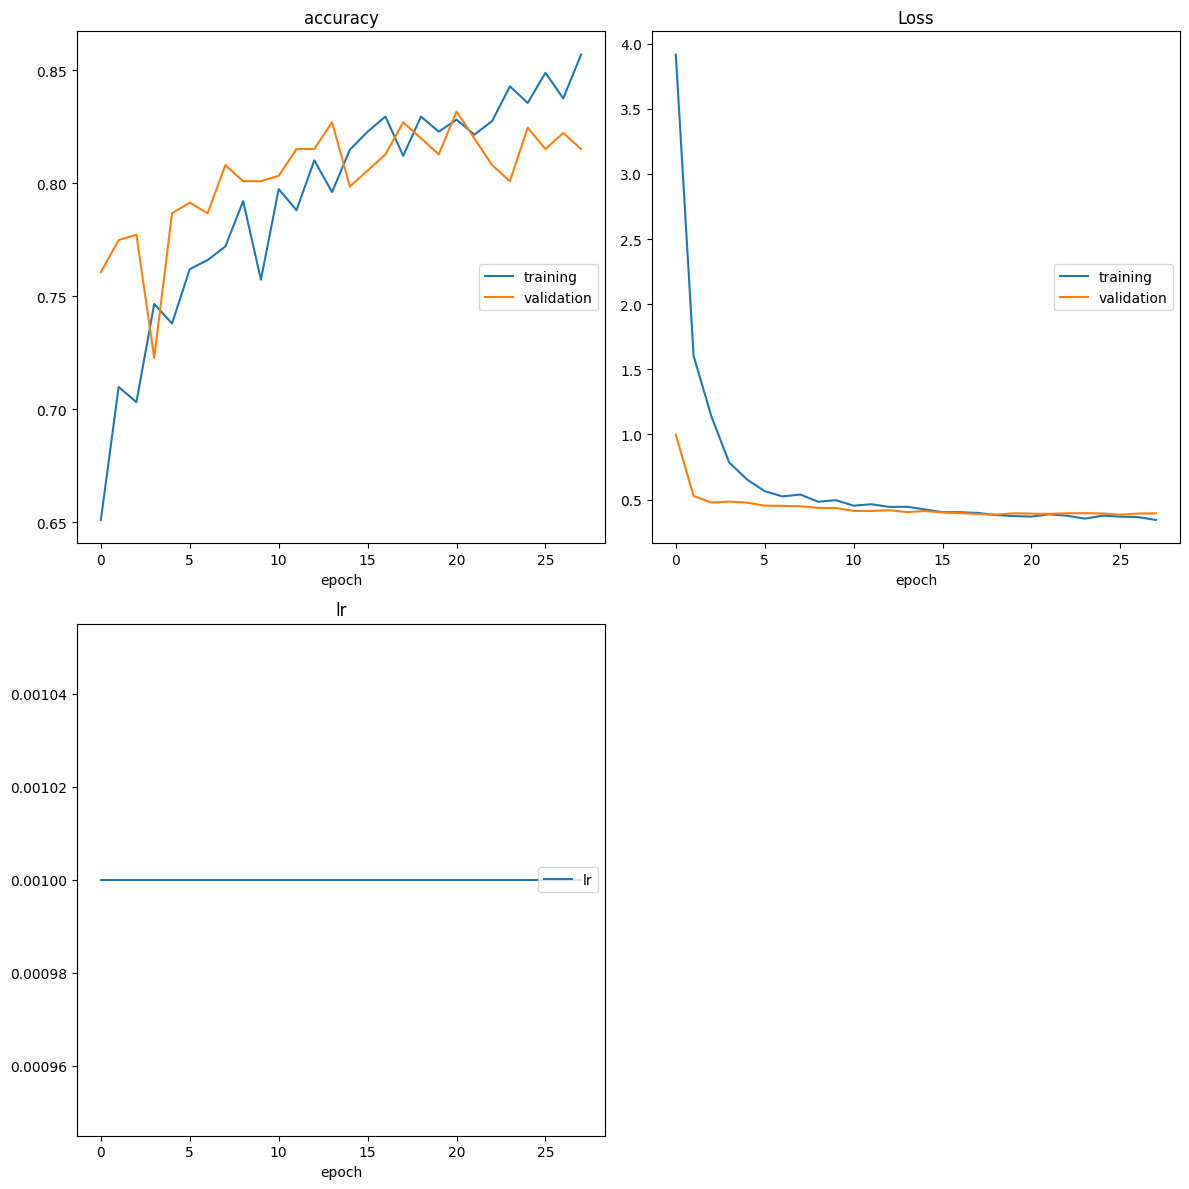

accuracy
	training         	 (min:    0.651, max:    0.857, cur:    0.857)
	validation       	 (min:    0.723, max:    0.832, cur:    0.815)
Loss
	training         	 (min:    0.344, max:    3.916, cur:    0.344)
	validation       	 (min:    0.384, max:    0.999, cur:    0.395)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
47/47 [==============================] - 85s 2s/step - loss: 0.3437 - accuracy: 0.8570 - val_loss: 0.3948 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 28: early stopping


In [ ]:
# Create and fit the model, or reload a previously-fitted one

train = True

if train:

  model = create_model(
                    input_shape=X_train.shape[1:],
                    n_classes=2,
                    optimizer=Adam(learning_rate=0.001),
                    fine_tune=0
                    )

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=1
                    )

else:

  model = create_model(
                    input_shape=X_train.shape[1:],
                    n_classes=2,
                    optimizer=Adam(learning_rate=0.001),
                    fine_tune=0,
                    weights_file="/content/drive/MyDrive/best_model.keras"
                    )

In [ ]:
# Use the model to make predictions for the test data

def get_predictions(model, test_data):

  # Create a copy of the test data to ensure it doesn't get altered by preprocess_input
  test_processed = np.copy(test_data)

  # Process the test data in the same way as the training and val data
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  test_generator = test_datagen.flow(test_processed, batch_size=32, shuffle=False)

  # Use model to obtain predictions on rescaled, mean-subtracted test dataset
  y_pred = model.predict(test_generator)

  # Convert probabilities to **binary** classes using threshold=0.5
  y_class = (y_pred > 0.5).astype(int)

  return y_pred, y_class

y_prob, y_class = get_predictions(model, X_test)

7/7 [==============================] - 10s 1s/step


In [ ]:
# Generate sklearn classification report

print('\n', classification_report(y_test, y_class))


               precision    recall  f1-score   support

           0       0.82      0.77      0.80       102
           1       0.81      0.85      0.83       112

   micro avg       0.81      0.81      0.81       214
   macro avg       0.81      0.81      0.81       214
weighted avg       0.81      0.81      0.81       214
 samples avg       0.81      0.81      0.81       214



40 out of 214 images were misclassified
174 out of 214 images were correctly classified


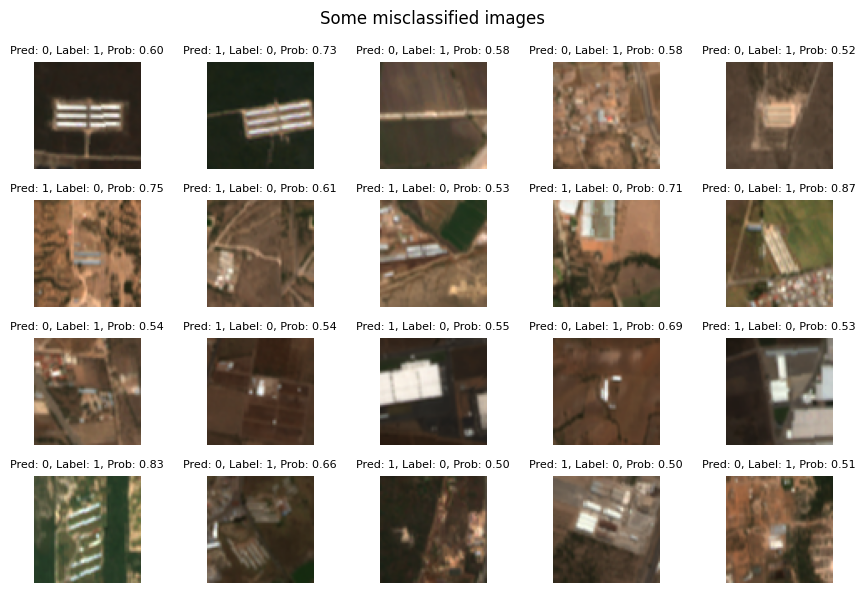

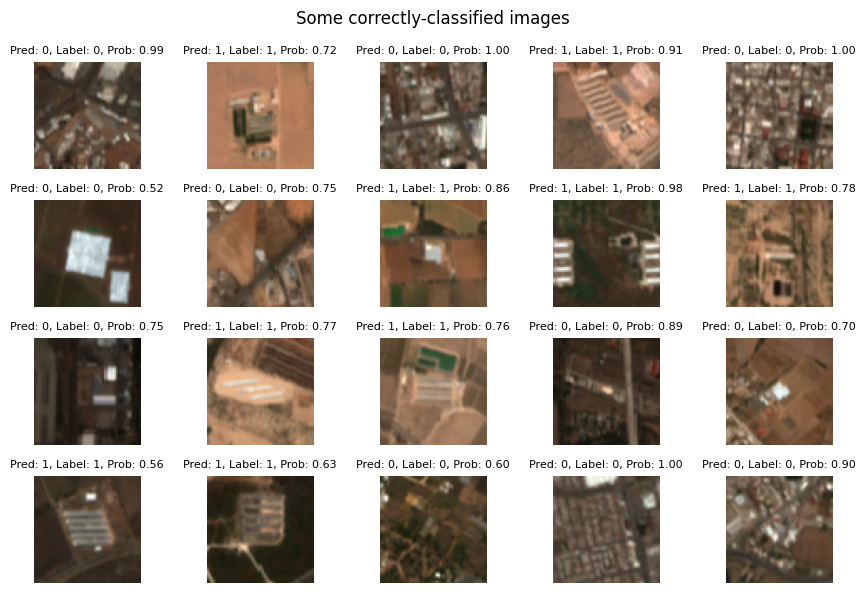

In [ ]:
# Display some properly-classified and misclassified images

def plot_classified(X_test, y_prob, y_test):

    # Find indices of (mis)classified images
    misclassified_indices = []
    correct_indices = []
    for idx, (truth, prediction) in enumerate(zip(y_test.astype(int), y_prob)):
      if np.argmax(truth) != np.argmax(prediction):
          misclassified_indices.append(idx)
      else:
          correct_indices.append(idx)

    print(f'{len(misclassified_indices)} out of {len(y_test)} images were misclassified')
    print(f'{len(correct_indices)} out of {len(y_test)} images were correctly classified')

    # Display the first 20 of each type (mislassified or correctly-classified)

    def make_plot(which, title):
      plt.figure(figsize=(9, 6))
      for i, index in enumerate(which[:20]):
          plt.subplot(4, 5, i + 1)
          img = X_test[index].reshape(64, 64, 3)
          img = (img / np.max(img)) * 255

          plt.imshow(img.astype(int))

          pred = np.argmax(y_prob[index])
          label = np.argmax(y_test[index])
          prob = y_prob[index][pred]
          plt.title(f"Pred: {pred}, Label: {label}, Prob: {prob:.2f}",\
                    fontsize=8)
          plt.axis('off')
          plt.suptitle(title)
      plt.tight_layout()
      plt.show()

    make_plot(misclassified_indices, "Some misclassified images")
    make_plot(correct_indices, "Some correctly-classified images")

plot_classified(X_test_original, y_prob, y_test)


Let's see if we can clean up the training data. We'll get the model to make predictions for the <i>training</i> data, then see if confidently wrong predictions correspond to CAFOs present in the training data.

In [ ]:
y_prob_train, _ = get_predictions(model, X_train_original)

47/47 [==============================] - 67s 1s/step


In [ ]:

# Find cases where prediction=1 but label=0

def potentially_mislabelled(X_train, y_train, y_prob):

  indices = []
  for idx, (label, probs) in enumerate(zip(y_train.astype(int), y_prob)):
    if np.argmax(probs) == 1 and np.argmax(label) == 0:
      indices.append(idx)

  misclassified = X_train[indices]
  probs = np.array([y[1] for y in y_prob[indices]])
  print(f"{len(misclassified)} images were misclassified as cat 1")

  ind = np.argsort(probs)
  ind = ind[::-1]
  probs = probs[ind]
  misclassified = misclassified[ind]

  return misclassified, probs, indices

misclass_imgs, misclass_probs, misclass_indices = \
               potentially_mislabelled(X_train_original, y_train, y_prob_train)

123 images were misclassified as cat 1


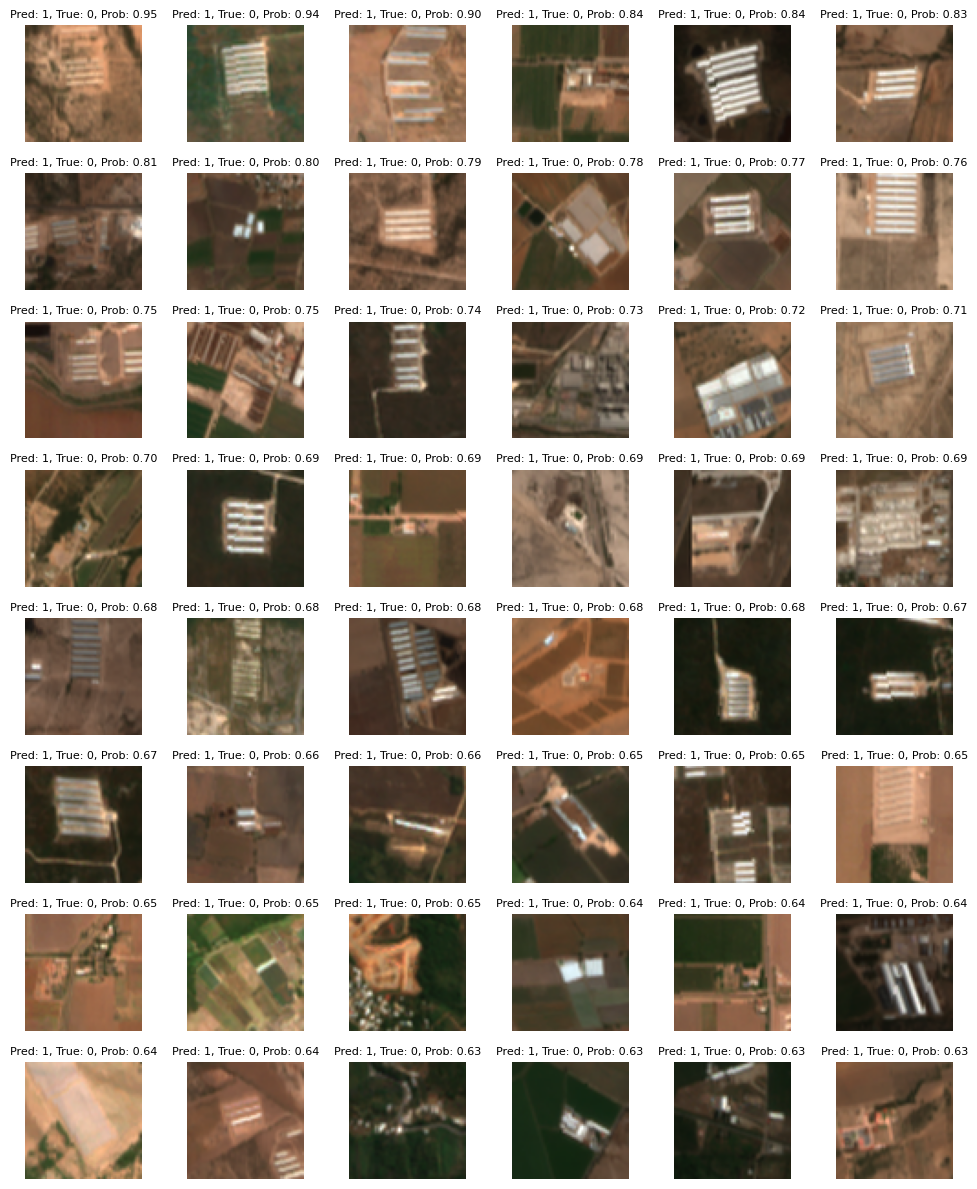

In [ ]:
# Display the first 48 images with prediction=1, label=0

def display_misclassified(images, probs, indices, y_train, y_prob_train):
  plt.figure(figsize=(10, 12))
  for i, img in enumerate(images[:48]):

      plt.subplot(8, 6, i + 1)
      img = (img / np.max(img)) * 255

      plt.imshow(img.astype(int))

      prob = probs[i]
      pred = np.argmax(y_prob_train[indices[i]])
      true = np.argmax(y_train[indices[i]])

      plt.title(f"Pred: {pred}, True: {true}, Prob: {prob:.2f}", fontsize=8)

      plt.axis('off')

  plt.tight_layout()

display_misclassified(misclass_imgs, misclass_probs, misclass_indices, y_train, y_prob_train)

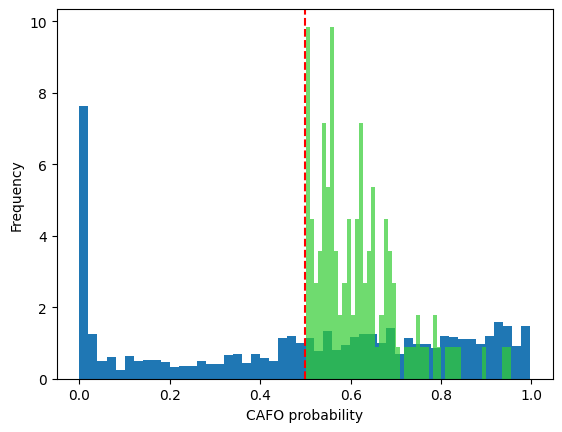

In [ ]:
# Distribution of probabilities, all predictions and prediction=1, label=0

def probability_hist(all_prob, misclass_prob):
  plt.hist([x[1] for x in all_prob], bins=50, density=True, stacked=True)
  plt.hist(misclass_prob, bins=50, density=True, stacked=True, color='limegreen', alpha=0.7)
  plt.axvline(0.5, color='r', ls='--')
  plt.xlabel("CAFO probability")
  plt.ylabel("Frequency")

probability_hist(y_prob_train, misclass_probs)

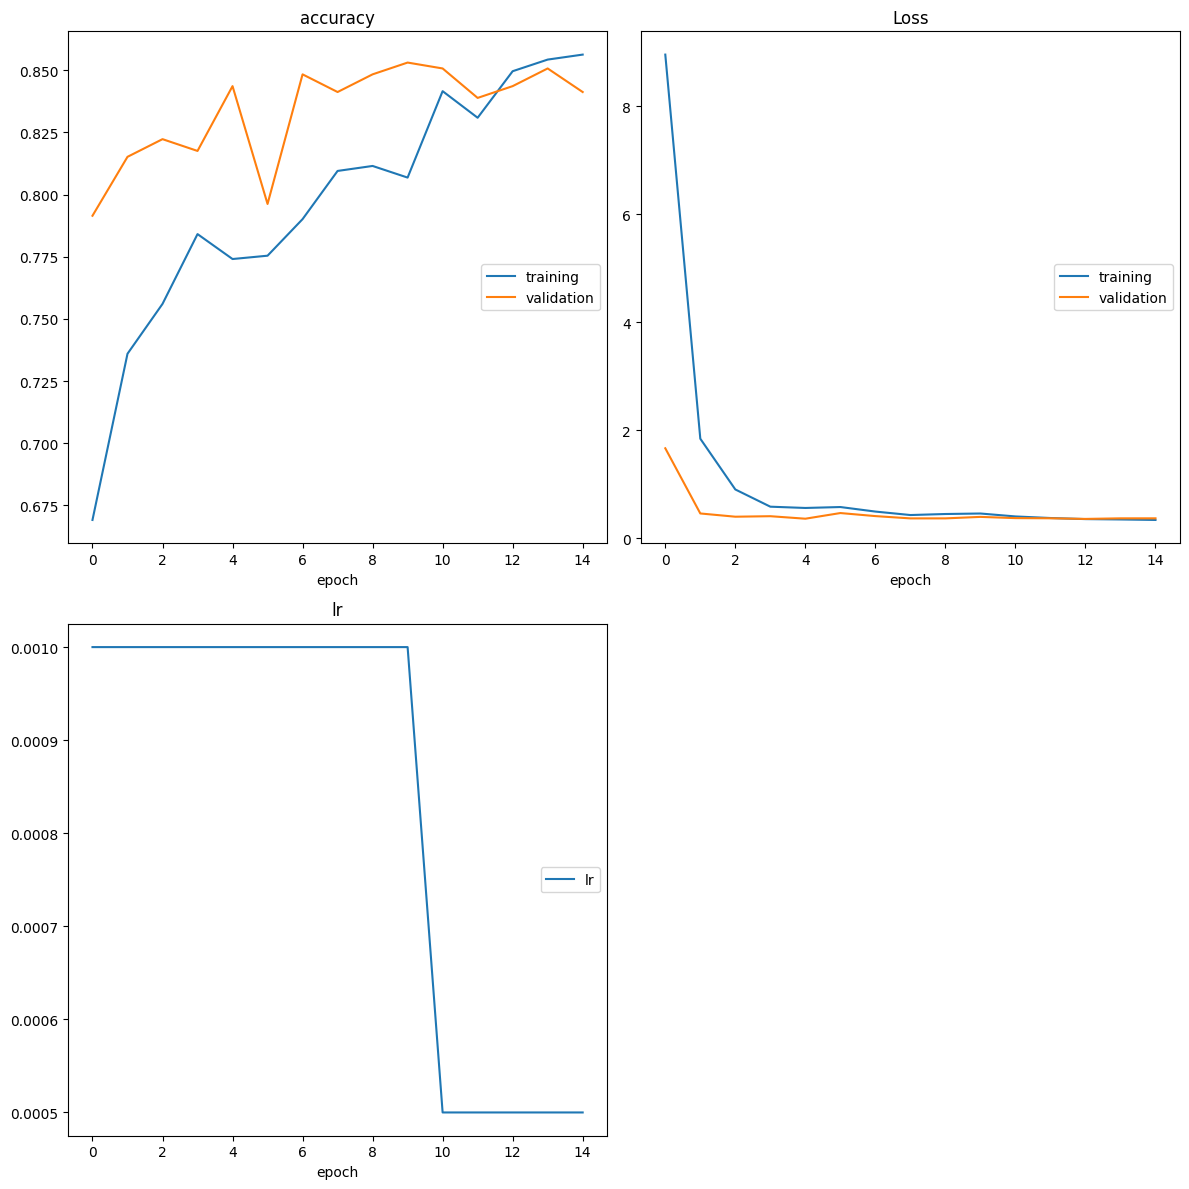

accuracy
	training         	 (min:    0.669, max:    0.856, cur:    0.856)
	validation       	 (min:    0.791, max:    0.853, cur:    0.841)
Loss
	training         	 (min:    0.335, max:    8.962, cur:    0.335)
	validation       	 (min:    0.354, max:    1.663, cur:    0.365)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
47/47 [==============================] - 93s 2s/step - loss: 0.3348 - accuracy: 0.8563 - val_loss: 0.3650 - val_accuracy: 0.8412 - lr: 5.0000e-04
Epoch 15: early stopping


In [ ]:
# Fine-tune the model

# Specify new filename for best model
mc = ModelCheckpoint(
                    'best_ft_model.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

# Create the new model with trainable layers
ft_model = create_model(
                    input_shape=X_train.shape[1:],
                    n_classes=2,
                    optimizer=Adam(learning_rate=0.001),
                    fine_tune=2
                    )


# Fit the model
ft_history = ft_model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, mc, es, pl],
                    verbose=1
                    )

7/7 [==============================] - 10s 1s/step

               precision    recall  f1-score   support

           0       0.78      0.86      0.82       102
           1       0.86      0.78      0.82       112

   micro avg       0.82      0.82      0.82       214
   macro avg       0.82      0.82      0.82       214
weighted avg       0.82      0.82      0.82       214
 samples avg       0.82      0.82      0.82       214

39 out of 214 images were misclassified
175 out of 214 images were correctly classified


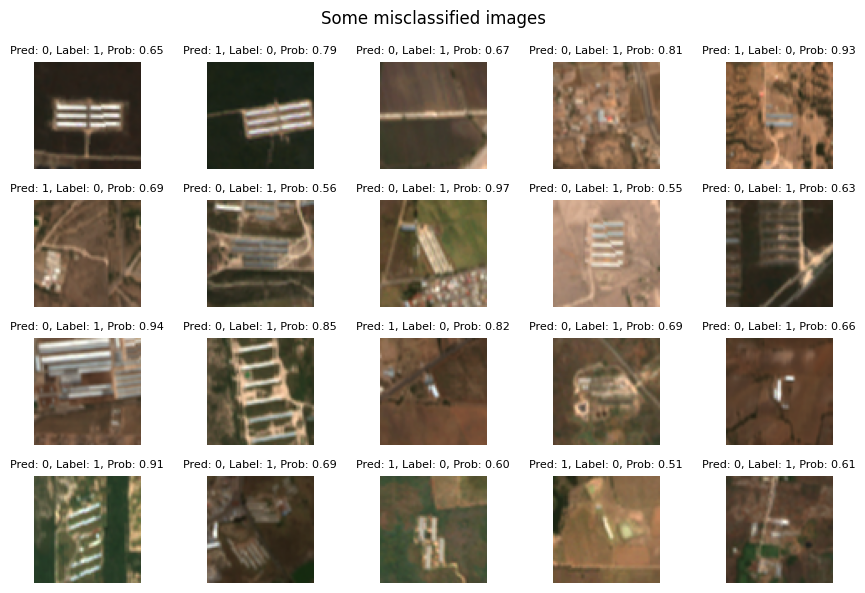

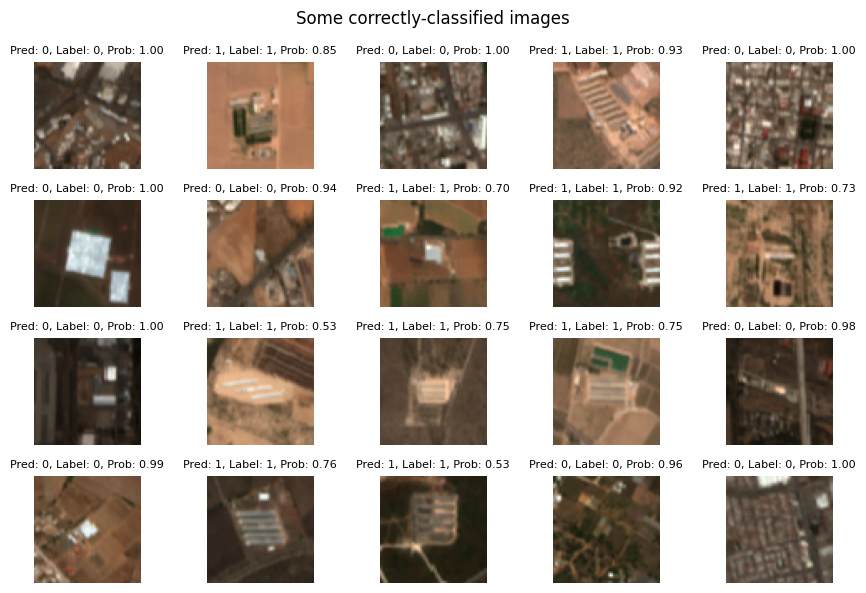

In [ ]:
y_prob_ft, y_class_ft = get_predictions(ft_model, X_test)

print('\n', classification_report(y_test, y_class_ft))

plot_classified(X_test_original, y_prob_ft, y_test)

In [ ]:
y_prob_ft_train, _ = get_predictions(ft_model, X_train_original)
misclass_imgs_ft, misclass_probs_ft, misclass_idx_ft = \
                  potentially_mislabelled(X_train_original, y_train, y_prob_ft_train)

 6/47 [==>...........................] - ETA: 51s

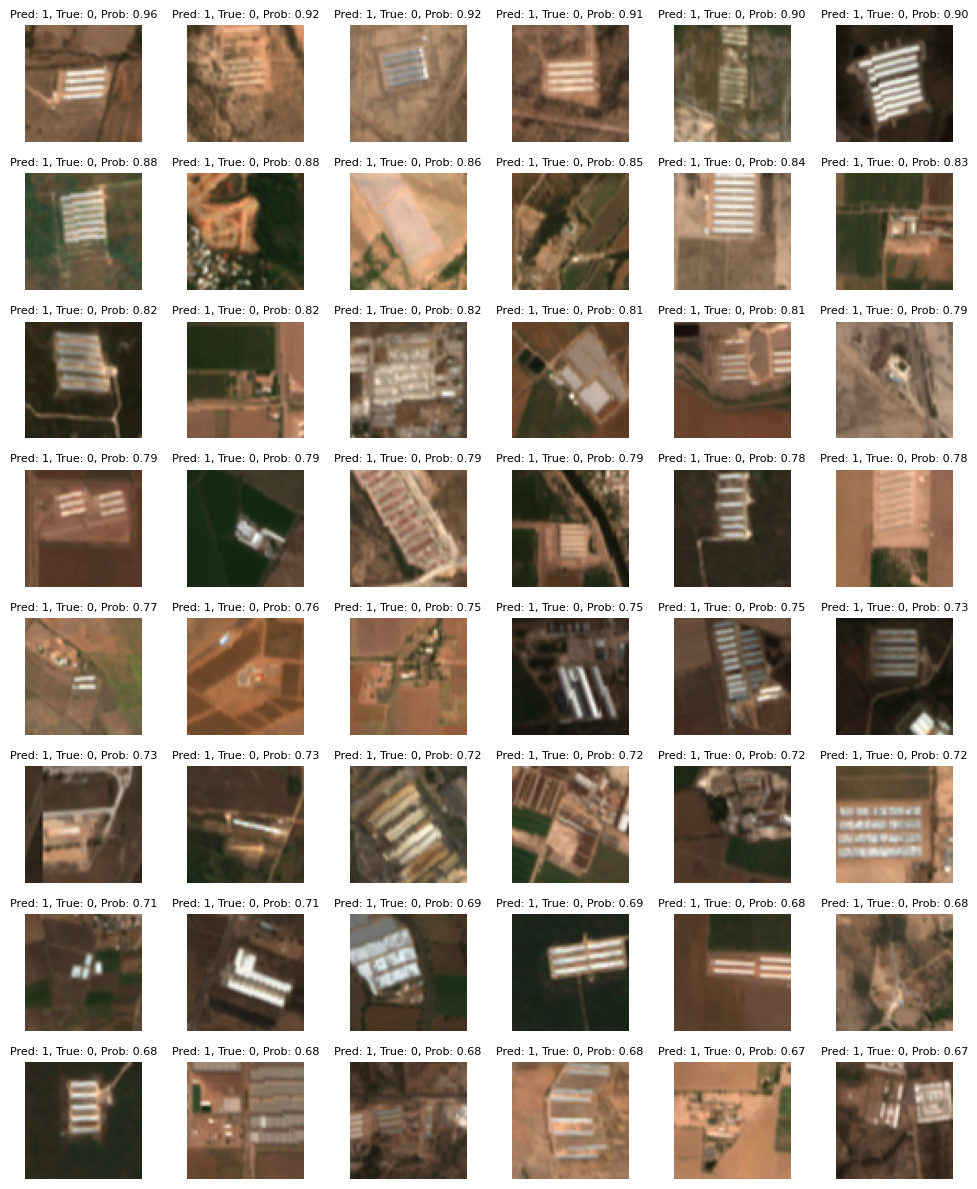

In [ ]:
display_misclassified(misclass_imgs_ft, misclass_probs_ft, misclass_idx_ft, y_train, y_prob_ft_train)

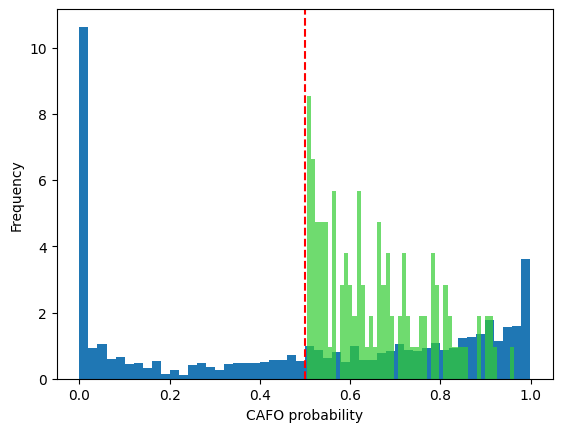

In [ ]:
probability_hist(y_prob_ft_train, misclass_probs_ft)